<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_5/Notebook_3_Image_augumentation_8.4Kparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NoteBook 3:-
##Target:

* Add Image augumentation of random Rotation with an range of (7,-7)
* Use One Cycle LR to modeify the Learning rate of Optimizer

## Results: 
* Paramerters: **8,444**
* Best Train Accuracy: **97.43**
* Best Test Accuracy: **99.40 (11th Epoch) and 99.41 (15th Epoch)**

## Analysis:
* Model is underfitting but test accuracy is up
* Acheived test accuracy of 99.41 at 15 epoch
* Schedular has Helped in fluctuations in the Accuracy. 
* Accuracy Can be made more consistent after 99.40. 
* Paramters can be reduced by decreasing kernel count. 

## **Imports**

In [ ]:
!pip install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR,OneCycleLR

## **Network Design**

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    # Conv Block 1
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Dropout(0.1)
    ) # output: 26x26

    # Conv Block 2
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.1)
    ) # output: 24x24

    # Pooling Layer 1
    self.pool1 = nn.MaxPool2d(2, 2) 

    # Transition Block 1
    self.trans_block1 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
    ) # Output: 12x12

    # Conv Block 3
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(0.1)
    ) # output: 10x10

    # Conv Block 4
    self.conv_block4 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.1)
    ) # output: 8x8

    # Conv Block 5
    self.conv_block5 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.1)
    ) # output: 6x6

    # Conv Block 6
    # Added this block with padding 1 to increase parameters
    # In our exprimentation we observed that with out these parameters are 
    # and accuracy is
    # After adding this accuracy got increased to 99.41
    self.conv_block6 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout(0.1)
    ) # output: 6x6

    # Avg Pooling
    self.avg_pool = nn.AvgPool2d(kernel_size=4)

    # Conv Block 7
    self.conv_block7 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.pool1(x)
    x = self.trans_block1(x)
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.conv_block5(x)
    x = self.conv_block6(x)
    x = self.avg_pool(x)
    x = self.conv_block7(x)

    x = x.view(-1, 10)
    return F.log_softmax(x, dim=1)

## **Model Summary**

In [ ]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

network = Network()
network.to(device)

summary(network, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

## **Dwonload Train, Test Data and apply Transformations**

In [ ]:
train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose(
        [
         # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
         transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
         transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
) # Download Train data

test_data = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose(
        [
         transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
) # Download Test Data

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## **Load Data - Data Loader**

In [ ]:
SEED = 1

torch.manual_seed(SEED)
cuda = torch.cuda.is_available()

if cuda:
  torch.manual_seed(SEED)

data_loader_arguments = dict(batch_size=128, shuffle=True, num_workers=4, pin_memory=True) if cuda else dict(batch_size=64, shuffle=True)

train_loader = torch.utils.data.DataLoader(train_data, **data_loader_arguments)
test_loader = torch.utils.data.DataLoader(test_data, **data_loader_arguments)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## **Train Step**

In [ ]:
from tqdm import tqdm

train_losses = []
train_accuracy = []

def train(model, train_loader, device, optimizer, epoch):
  model.train()
  correct = 0
  processed = 0
  pbar = tqdm(train_loader)
  for idx, (images, target) in enumerate(pbar):
    images, target = images.to(device), target.to(device)

    optimizer.zero_grad()
    y_pred = model(images)
    loss = F.nll_loss(y_pred, target)

    train_losses.append(loss)

    loss.backward()
    optimizer.step()
    scheduler.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Epoch{epoch} : Loss={loss.item()} Batch_id={idx} Accuracy={100*correct/processed:0.2f}')
    train_accuracy.append(100*correct/processed)

## **Test Step**

In [ ]:
test_losses = []
test_accuracy = []

def test(model, test_loader, device):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      y_pred = model(data)
      # Batch Loss
      test_loss += F.nll_loss(y_pred, target, reduction='sum').item() 

      pred = y_pred.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /=len(test_loader.dataset)
  test_losses.append(test_loss) # Avg Test Loss

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
  
  test_accuracy.append(100*correct/len(test_loader.dataset))

## **Optimizer and LR Scheduler**

In [ ]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.01,epochs=15,steps_per_epoch=len(train_loader))

In [ ]:
for epoch in range(1, 16):
  train(network, train_loader, device, optimizer, epoch)
  test(network, test_loader, device)

Epoch1 : Loss=1.0805463790893555 Batch_id=468 Accuracy=46.33: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.5598, Accuracy: 8649/10000 (86.49%)



Epoch2 : Loss=0.323241263628006 Batch_id=468 Accuracy=86.28: 100%|██████████| 469/469 [00:33<00:00, 13.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.1163, Accuracy: 9673/10000 (96.73%)



Epoch3 : Loss=0.21931077539920807 Batch_id=468 Accuracy=92.74: 100%|██████████| 469/469 [00:34<00:00, 13.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0682, Accuracy: 9782/10000 (97.82%)



Epoch4 : Loss=0.10104476660490036 Batch_id=468 Accuracy=94.64: 100%|██████████| 469/469 [00:33<00:00, 13.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0473, Accuracy: 9844/10000 (98.44%)



Epoch5 : Loss=0.21033455431461334 Batch_id=468 Accuracy=95.34: 100%|██████████| 469/469 [00:33<00:00, 13.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0338, Accuracy: 9892/10000 (98.92%)



Epoch6 : Loss=0.1057480201125145 Batch_id=468 Accuracy=95.87: 100%|██████████| 469/469 [00:34<00:00, 13.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0361, Accuracy: 9898/10000 (98.98%)



Epoch7 : Loss=0.2255791574716568 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:34<00:00, 13.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0287, Accuracy: 9910/10000 (99.10%)



Epoch8 : Loss=0.10691715031862259 Batch_id=468 Accuracy=96.50: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0301, Accuracy: 9904/10000 (99.04%)



Epoch9 : Loss=0.07491565495729446 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:33<00:00, 13.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0278, Accuracy: 9920/10000 (99.20%)



Epoch10 : Loss=0.1145995557308197 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:34<00:00, 13.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)



Epoch11 : Loss=0.061837807297706604 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:34<00:00, 13.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)



Epoch12 : Loss=0.062073156237602234 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:34<00:00, 13.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)



Epoch13 : Loss=0.10104188323020935 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:34<00:00, 13.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)



Epoch14 : Loss=0.1001758798956871 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)



Epoch15 : Loss=0.08755002170801163 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:34<00:00, 13.72it/s]


Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)



## **Data Statistics**

In [ ]:
train = train_data.train_data

print('[Train]')
print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.train_data.size())
print(' - min:', torch.min(train))
print(' - max:', torch.max(train))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


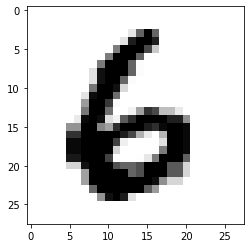

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

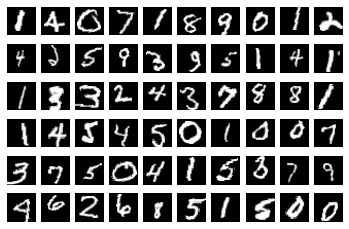

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
      plt.subplot(6, 10, index)
      plt.axis('off')
      plt.imshow(images[index].numpy().squeeze(), cmap='gray')